# Week 10 Lab: Machine Learning Force Fields (ML-FF)

## Student Name: YOUR NAME HERE

## Preamble

### Dataset needed

* Before we begin, please start the download the dataset needed for training: [QM dataset needed](https://figshare.com/articles/dataset/ANI-1_data_set_20M_DFT_energies_for_non-equilibrium_small_molecules/5287732). This is a 4.48 GB `tar` file.
* Next, please decompress the `tar` file. This can be done on WinOS with [7zip](https://www.7-zip.org), or Linux/Mac with the command `$ tar -xf ANI1_release.tar.gz`

### Packages needed

In [1]:
# This cell will install any of the missing packages we'll use in the notebook
import sys
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install torchani
!{sys.executable} -m pip install tqdm
!{sys.executable} -m pip install tensorboard
!{sys.executable} -m pip install h5py

# ML-FF: ANI-1 exercise

In [2]:
%matplotlib inline

## Train Your Own Neural Network Potential

This example shows how to use TorchANI to train a neural network potential
with the setup identical to NeuroChem. We will use the same configuration as
specified in [`inputtrain.ipt`](https://github.com/aiqm/torchani/blob/master/torchani/resources/ani-1x_8x/inputtrain.ipt). 

<div class="alert alert-info"><h4>Note</h4><p>TorchANI provide tools to run NeuroChem training config file `inputtrain.ipt`.
    See: `neurochem-training`.</p></div>

<div class="alert alert-danger"><h4>Warning</h4><p>The training setup used in this file is configured to reproduce the original research at "Less is more: Sampling chemical space with active learning" (https://aip.scitation.org/doi/10.1063/1.5023802) as much as possible. 
    That research was done on a different platform called NeuroChem which has many default options and technical details different from PyTorch. Some decisions made here (such as, using NeuroChem's initialization instead of PyTorch's default initialization) is not because it gives better result, but solely based on reproducing the original research. This file should not be interpreted as a suggestions to the readers on how they should setup their models.</p></div>

To begin with, let's first import the modules and setup devices we will use:



In [21]:
import torch
import torchani
import os
import math
import torch.utils.tensorboard
import tqdm

# helper function to convert energy unit from Hartree to kcal/mol
from torchani.units import hartree2kcalmol

# device to run the training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Now let's setup constants and construct an Atomic Environment Vector (AEV) computer. 
* These numbers can be found in [`rHCNO-5.2R_16-3.5A_a4-8.params`](https://github.com/aiqm/torchani/blob/master/torchani/resources/ani-1x_8x/rHCNO-5.2R_16-3.5A_a4-8.params). 
* The atomic self energies given in [`sae_linfit.dat`](https://github.com/aiqm/torchani/blob/master/torchani/resources/ani-1x_8x/sae_linfit.dat) are computed from ANI-1x
dataset. These constants can be calculated for any given dataset if ``None``
is provided as an argument to the object of :class:`EnergyShifter` class.

<div class="alert alert-info"><h4>Note</h4><p>Besides defining these hyperparameters programmatically,
  :mod:`torchani.neurochem` provide tools to read them from file.</p></div>

* These parameters have suffix `r` for the radial and `a` for angular functions (See equations 3 and 4 of [`smith2017-1`](https://doi.org/10.1039/C6SC05720A)).

In [22]:
Rcr = 5.2000e+00
Rca = 3.5000e+00
EtaR = torch.tensor([1.6000000e+01], device=device)
ShfR = torch.tensor([9.0000000e-01, 1.1687500e+00, 1.4375000e+00, 1.7062500e+00, 1.9750000e+00, 2.2437500e+00, 2.5125000e+00, 2.7812500e+00, 3.0500000e+00, 3.3187500e+00, 3.5875000e+00, 3.8562500e+00, 4.1250000e+00, 4.3937500e+00, 4.6625000e+00, 4.9312500e+00], device=device)
Zeta = torch.tensor([3.2000000e+01], device=device)
ShfZ = torch.tensor([1.9634954e-01, 5.8904862e-01, 9.8174770e-01, 1.3744468e+00, 1.7671459e+00, 2.1598449e+00, 2.5525440e+00, 2.9452431e+00], device=device)
EtaA = torch.tensor([8.0000000e+00], device=device)
ShfA = torch.tensor([9.0000000e-01, 1.5500000e+00, 2.2000000e+00, 2.8500000e+00], device=device)
species_order = ['H', 'C', 'N', 'O']
num_species = len(species_order)
aev_computer = torchani.AEVComputer(Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species)
energy_shifter = torchani.utils.EnergyShifter(None)

**Remember the modified Behler-Parrinello functions from last lecture:**

![ANI G-function figure](https://github.com/ADicksonLab/ml4md-jb/blob/main/Week-10/ANI.png?raw=true)

where

$$
f_{\mathrm{c}} = \left\{
\begin{array}{lc}
0.5\left[ \cos\left( \frac{\pi R_{ij}}{R_{\mathrm{c}}} \right) +1 \right] & \text{ if } R_{ij} \leq R_{\mathrm{c}} \\
0 & \text{ otherwise}
\end{array}
%
\right.
$$

The correspondence is as follows:

*  `Rcr` : The $R_C$ value in the $f_C$ term for the radial functions (Å)
*  `Rca` : The $R_C$ value in the $f_C$ term for the angular functions (Å)
*  `EtaR` : A set of $\eta$ values to use for the radial functions (Å$^{-2}$)
*  `ShfR` : A set of $R_s^{(k)}$ values ("shifts") to use for the radial functions (Å)
*  `Zeta` : A set of $\zeta$ values to use in the angular functions
*  `ShfZ` : A set of $\theta_s^{(q)}$ values to use in the angular functions (radians)
*  `EtaA` : A set of $\eta$ values to use for the angular functions (Å$^{-2}$)
*  `ShfA` : A set of $R_s^{(p)}$ values ("shifts") to use for the angular functions (Å)

## Setting up your datasets

* Now let's setup datasets. These paths assumes the user run this script under the ``examples`` directory of TorchANI's repository. If you download this script, you should manually set the path of these files in your system before this script can run successfully. 

* Also note that we need to subtracting energies by the self energies of all atoms for each molecule. This makes the range of energies in a reasonable range. The second argument defines how to convert species as a list of string to tensor, that is, for all supported chemical symbols, which is correspond to ``0``, which correspond to ``1``, etc.

* See this [Dataset description](https://github.com/isayev/ANI1_dataset#description) for a explanation and details of this dataset.

##### WARNING 
* Please fix the variable `pathprefix` for your system. It must be the path to the folder containing the ANI `h5` files (the ones from the 4.48 GB `tar` file linked at the beginning). 

In [23]:
#Additional#
pathprefix = "../../ANI-1_release/"

In [24]:
#Additional#
# Check if the files are in the folder (only check for the first one)
import os.path
if not os.path.isfile(os.path.join(pathprefix,"ani_gdb_s01.h5")):
    print("Can't find the ANI h5 files in folder "+pathprefix)
    for i in range(5):
        print("^")
else:
    print("ANI h5 files located!")

ANI h5 files located!


In [73]:
try:
    path = os.path.dirname(os.path.realpath(__file__))
except NameError:
    path = os.getcwd()
#dspath = os.path.join(path, '../dataset/ani1-up_to_gdb4/ani_gdb_s01.h5') # <- Original line:
dspath = os.path.join(path, pathprefix+'/ani_gdb_s04.h5')
batch_size = 2560
#batch_size = 10240

# Additional#: Here the dataset is split into training and validation set
training, validation = torchani.data.load(dspath).subtract_self_energies(energy_shifter, species_order).species_to_indices(species_order).shuffle().split(0.8, None)
training = training.collate(batch_size).cache()
validation = validation.collate(batch_size).cache()
print('Self atomic energies: ', energy_shifter.self_energies)

Self atomic energies:  tensor([ -0.6126, -38.0601, -54.7065, -75.1870], dtype=torch.float64)


When iterating the dataset, we will get a dict of name->property mapping

---
**Now let's define atomic neural networks.**



## Setting up your Architecture

**Additional#** Here the different neural networks (one for each atom) are initialized.
* The even-index elements of the NNs are the hidden layers. For example, `torch.nn.Linear(160, 128)` means that the previous layer has 160 neurons and the current layer has 128 neurons.
* The odd-index elements are the activation functions. The function used is the 'Continuously differentiable Exponential Linear Units' (CELU), see https://pytorch.org/docs/stable/generated/torch.nn.CELU.html#torch.nn.CELU
    * Its argument is the alpha value of the CELU formulation (not related to the learning rate)

`aev_dim` stores the length (384) of the atomic environment vectors (AEV). See section 2.2 of `smith2017-1`. (Note: Said paper, in page 9, says that the AEVs have length 768. The AEVs were later shortened to 368 without loss of accuracy)

All 4 neural networks are loaded on `nn` for optimization.

In [74]:
aev_dim = aev_computer.aev_length

H_network = torch.nn.Sequential(
    torch.nn.Linear(aev_dim, 160),
    torch.nn.CELU(0.1),
    torch.nn.Linear(160, 128),
    torch.nn.CELU(0.1),
    torch.nn.Linear(128, 96),
    torch.nn.CELU(0.1),
    torch.nn.Linear(96, 1)
)

C_network = torch.nn.Sequential(
    torch.nn.Linear(aev_dim, 144),
    torch.nn.CELU(0.1),
    torch.nn.Linear(144, 112),
    torch.nn.CELU(0.1),
    torch.nn.Linear(112, 96),
    torch.nn.CELU(0.1),
    torch.nn.Linear(96, 1)
)

N_network = torch.nn.Sequential(
    torch.nn.Linear(aev_dim, 128),
    torch.nn.CELU(0.1),
    torch.nn.Linear(128, 112),
    torch.nn.CELU(0.1),
    torch.nn.Linear(112, 96),
    torch.nn.CELU(0.1),
    torch.nn.Linear(96, 1)
)

O_network = torch.nn.Sequential(
    torch.nn.Linear(aev_dim, 128),
    torch.nn.CELU(0.1),
    torch.nn.Linear(128, 112),
    torch.nn.CELU(0.1),
    torch.nn.Linear(112, 96),
    torch.nn.CELU(0.1),
    torch.nn.Linear(96, 1)
)

nn = torchani.ANIModel([H_network, C_network, N_network, O_network])
print(nn)

ANIModel(
  (0): Sequential(
    (0): Linear(in_features=384, out_features=160, bias=True)
    (1): CELU(alpha=0.1)
    (2): Linear(in_features=160, out_features=128, bias=True)
    (3): CELU(alpha=0.1)
    (4): Linear(in_features=128, out_features=96, bias=True)
    (5): CELU(alpha=0.1)
    (6): Linear(in_features=96, out_features=1, bias=True)
  )
  (1): Sequential(
    (0): Linear(in_features=384, out_features=144, bias=True)
    (1): CELU(alpha=0.1)
    (2): Linear(in_features=144, out_features=112, bias=True)
    (3): CELU(alpha=0.1)
    (4): Linear(in_features=112, out_features=96, bias=True)
    (5): CELU(alpha=0.1)
    (6): Linear(in_features=96, out_features=1, bias=True)
  )
  (2): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): CELU(alpha=0.1)
    (2): Linear(in_features=128, out_features=112, bias=True)
    (3): CELU(alpha=0.1)
    (4): Linear(in_features=112, out_features=96, bias=True)
    (5): CELU(alpha=0.1)
    (6): Linear(in_features

## Initialize the weights and biases.

<div class="alert alert-info"><h4>Note</h4><p>Pytorch default initialization for the weights and biases in linear layers
  is Kaiming uniform. See: `TORCH.NN.MODULES.LINEAR`_
  We initialize the weights similarly but from the normal distribution.
  The biases were initialized to zero.</p></div>

  https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear



**Additional#** The Kaiming distribution improves the training of a DNN that uses a ReLU-type (unbounded) activation function rather than sigmoid-type (within the interval (-1,1) or (0,1) ). For a complete account on the topic, see https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79 .

This other read is not as didactic but derives the Kaiming initialization https://medium.com/@shoray.goel/kaiming-he-initialization-a8d9ed0b5899

In [75]:
def init_params(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, a=1.0)
        torch.nn.init.zeros_(m.bias)


nn.apply(init_params)

ANIModel(
  (0): Sequential(
    (0): Linear(in_features=384, out_features=160, bias=True)
    (1): CELU(alpha=0.1)
    (2): Linear(in_features=160, out_features=128, bias=True)
    (3): CELU(alpha=0.1)
    (4): Linear(in_features=128, out_features=96, bias=True)
    (5): CELU(alpha=0.1)
    (6): Linear(in_features=96, out_features=1, bias=True)
  )
  (1): Sequential(
    (0): Linear(in_features=384, out_features=144, bias=True)
    (1): CELU(alpha=0.1)
    (2): Linear(in_features=144, out_features=112, bias=True)
    (3): CELU(alpha=0.1)
    (4): Linear(in_features=112, out_features=96, bias=True)
    (5): CELU(alpha=0.1)
    (6): Linear(in_features=96, out_features=1, bias=True)
  )
  (2): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): CELU(alpha=0.1)
    (2): Linear(in_features=128, out_features=112, bias=True)
    (3): CELU(alpha=0.1)
    (4): Linear(in_features=112, out_features=96, bias=True)
    (5): CELU(alpha=0.1)
    (6): Linear(in_features

**Let's now create a pipeline of AEV Computer --> Neural Networks.**



In [76]:
model = torchani.nn.Sequential(aev_computer, nn).to(device)

Now let's setup the optimizers. NeuroChem uses Adam with decoupled weight decay
to updates the weights and Stochastic Gradient Descent (SGD) to update the biases.
Moreover, we need to specify different [weight decay rate]( https://arxiv.org/abs/1711.05101) for different layers.

<div class="alert alert-info"><h4>Note</h4><p>The weight decay in `inputtrain.ipt`_ is named "l2", but it is actually not
  L2 regularization. The confusion between L2 and weight decay is a common
  mistake in deep learning.  See: `Decoupled Weight Decay Regularization`_
  Also note that the weight decay only applies to weight in the training
  of ANI models, not bias.</p></div>

 



## Setting up the Optimization Functions

* Here the optimization is set up. 
* Only the even-index elements are selected since the odd elements are the activation functions.

#### The Adam(s) algorithm.
The weights are optimized by AdamW, a variant of the Adam optimization method. 
* A good introduction to the [Adam Optimizer](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) 
* The original paper [Adam paper](https://arxiv.org/pdf/1412.6980.pdf)
* A more general overview of [gradient descent methods](https://arxiv.org/pdf/1609.04747.pdf), which includes SGD and the Adam variants. 

A few points about Adam:
* it can be seen as an extension of SGD.
* the method is called Adam (not A.D.A.M. or such). The name is derived from ADAptive Moment estimation.
* easy to implement and understand.
* appropriate for problems with large amounts of data, parameters, and noisy/sparse gradients.
* SGD uses one learning rate for all parameters; Adam uses one for each parameter.
* It's a refinement of the momentum optimization method.
* The momentum method emulates a ball moving in a ravine: the ball's future position depends on the ravine's gradient AND on the ball's momentum.
* The momentum method updates its parameters by
\begin{equation}
\Delta \theta_i(t) = \alpha \cdot \Delta \theta_i(t-1) - \epsilon \frac{\partial J}{\partial \theta_i}(t)
\end{equation}
    * $\Delta \theta_i$ is the change in the parameter $\theta_i$ for the epoch $t$.
    * $\alpha$ is the momentum hyperparameter, usually $\in [0.5,0.9]$.
    * $\Delta \theta_i(t-1)$ is the previous change on $\theta_i$.
    * $\epsilon$ is the learning rate.
    * $\partial J/\partial \theta_i$ is the derivative of the cost function wrt $\theta_i$ for the current epoch.
    * It can be seen in the equation above that the Momentum method updates the model's parameters using the *rolling average* of the gradient across the previous iterations, instead of relying solely in the current gradient.
* The Adam method takes these refinements one step further, as it not only stores the *rolling average of the gradient*, denoted above as $\alpha \cdot \Delta \theta_i(t-1)$, but also the *rolling average of the squared gradient*. It uses both to tweak each parameter's learning rate separately. For a deeper explanation of the method, see section 4.6 of the [gradient descent review](https://arxiv.org/pdf/1609.04747.pdf) or alternatively the [original Adam paper](https://arxiv.org/pdf/1412.6980.pdf).
* Finally, the AdamW method is a variant of Adam that includes a decoupled weight decay. According to the authors,

> we propose a simple modification to recover the original formulation of
weight decay regularization by decoupling the weight decay from the optimization
steps taken w.r.t. the loss function.

> We provide empirical evidence that our proposed modification...(ii) substantially improves Adam’s generalization performance, allowing it to compete with
SGD with momentum on image classification datasets (on which it was previously
typically outperformed by the latter).

For a deeper explanation, see the [authors' paper](https://arxiv.org/pdf/1711.05101.pdf).

Note that the biases below are optimized by SGD.

In [77]:
AdamW = torch.optim.AdamW([
    # H networks
    {'params': [H_network[0].weight]},
    {'params': [H_network[2].weight], 'weight_decay': 0.00001},
    {'params': [H_network[4].weight], 'weight_decay': 0.000001},
    {'params': [H_network[6].weight]},
    # C networks
    {'params': [C_network[0].weight]},
    {'params': [C_network[2].weight], 'weight_decay': 0.00001},
    {'params': [C_network[4].weight], 'weight_decay': 0.000001},
    {'params': [C_network[6].weight]},
    # N networks
    {'params': [N_network[0].weight]},
    {'params': [N_network[2].weight], 'weight_decay': 0.00001},
    {'params': [N_network[4].weight], 'weight_decay': 0.000001},
    {'params': [N_network[6].weight]},
    # O networks
    {'params': [O_network[0].weight]},
    {'params': [O_network[2].weight], 'weight_decay': 0.00001},
    {'params': [O_network[4].weight], 'weight_decay': 0.000001},
    {'params': [O_network[6].weight]},
])

SGD = torch.optim.SGD([
    # H networks
    {'params': [H_network[0].bias]},
    {'params': [H_network[2].bias]},
    {'params': [H_network[4].bias]},
    {'params': [H_network[6].bias]},
    # C networks
    {'params': [C_network[0].bias]},
    {'params': [C_network[2].bias]},
    {'params': [C_network[4].bias]},
    {'params': [C_network[6].bias]},
    # N networks
    {'params': [N_network[0].bias]},
    {'params': [N_network[2].bias]},
    {'params': [N_network[4].bias]},
    {'params': [N_network[6].bias]},
    # O networks
    {'params': [O_network[0].bias]},
    {'params': [O_network[2].bias]},
    {'params': [O_network[4].bias]},
    {'params': [O_network[6].bias]},
], lr=1e-3)

Setting up a learning rate scheduler to do learning rate decay



In [78]:
AdamW_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(AdamW, factor=0.5, patience=100, threshold=0)
SGD_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(SGD, factor=0.5, patience=100, threshold=0)

Train the model by minimizing the MSE loss, until validation RMSE no longer
improves during a certain number of steps, decay the learning rate and repeat
the same process, stop until the learning rate is smaller than a threshold.

We first read the checkpoint files to restart training. We use `latest.pt`
to store current training state.



In [79]:
latest_checkpoint = 'latest.pt'

Resume training from previously saved checkpoints:



In [67]:
if os.path.isfile(latest_checkpoint):
    checkpoint = torch.load(latest_checkpoint)
    nn.load_state_dict(checkpoint['nn'])
    AdamW.load_state_dict(checkpoint['AdamW'])
    SGD.load_state_dict(checkpoint['SGD'])
    AdamW_scheduler.load_state_dict(checkpoint['AdamW_scheduler'])
    SGD_scheduler.load_state_dict(checkpoint['SGD_scheduler'])

During training, we need to validate on validation set and if validation error
is better than the best, then save the new best model to a checkpoint



In [80]:
def validate():
    # run validation
    mse_sum = torch.nn.MSELoss(reduction='sum')
    total_mse = 0.0
    count = 0
    for properties in validation:
        species = properties['species'].to(device)
        coordinates = properties['coordinates'].to(device).float()
        true_energies = properties['energies'].to(device).float()
        _, predicted_energies = model((species, coordinates))
        total_mse += mse_sum(predicted_energies, true_energies).item()
        count += predicted_energies.shape[0]
    return hartree2kcalmol(math.sqrt(total_mse / count))

We will also use TensorBoard to visualize our training process



In [81]:
tensorboard = torch.utils.tensorboard.SummaryWriter()

## Training 

Finally, we come to the training loop.

In this tutorial, we are setting the maximum epoch to a very small number,
only to make this demo terminate fast. For serious training, this should be
set to a much larger value



In [82]:
#Additional# Run the code in this cell if you want to restart the training from zero
import os
try:
    os.remove("best.pt")
    os.remove("latest.pt")
except:
    pass

In [83]:
mse = torch.nn.MSELoss(reduction='none')

print("training starting from epoch", AdamW_scheduler.last_epoch + 1)
max_epochs = 50
early_stopping_learning_rate = 1.0E-5
best_model_checkpoint = 'best.pt'

# Additional# This is the big loop for optimization
for _ in range(AdamW_scheduler.last_epoch + 1, max_epochs):
    rmse = validate()
    print('RMSE:', rmse, 'at epoch', AdamW_scheduler.last_epoch + 1)

    learning_rate = AdamW.param_groups[0]['lr']

    if learning_rate < early_stopping_learning_rate:
        break

    # checkpoint
    if AdamW_scheduler.is_better(rmse, AdamW_scheduler.best):
        torch.save(nn.state_dict(), best_model_checkpoint)

    # Additional# OPTIMIZATION HAPPENS HERE v
    AdamW_scheduler.step(rmse)
    SGD_scheduler.step(rmse)

    tensorboard.add_scalar('validation_rmse', rmse, AdamW_scheduler.last_epoch)
    tensorboard.add_scalar('best_validation_rmse', AdamW_scheduler.best, AdamW_scheduler.last_epoch)
    tensorboard.add_scalar('learning_rate', learning_rate, AdamW_scheduler.last_epoch)

    for i, properties in tqdm.tqdm(
        enumerate(training),
        total=len(training),
        desc="epoch {}".format(AdamW_scheduler.last_epoch)
    ):
        species = properties['species'].to(device)
        coordinates = properties['coordinates'].to(device).float()
        true_energies = properties['energies'].to(device).float()
        num_atoms = (species >= 0).sum(dim=1, dtype=true_energies.dtype)
        _, predicted_energies = model((species, coordinates))

        # Additional# Compute the loss function
        loss = (mse(predicted_energies, true_energies) / num_atoms.sqrt()).mean()

        AdamW.zero_grad()
        SGD.zero_grad()
        loss.backward()
        AdamW.step()
        SGD.step()

        #print("nn", nn.state_dict())
        #print("AdamW", AdamW.state_dict())
        
        # write current batch loss to TensorBoard
        tensorboard.add_scalar('batch_loss', loss, AdamW_scheduler.last_epoch * len(training) + i)
        #print("loss",loss) # custom

    torch.save({
        'nn': nn.state_dict(),
        'AdamW': AdamW.state_dict(),
        'SGD': SGD.state_dict(),
        'AdamW_scheduler': AdamW_scheduler.state_dict(),
        'SGD_scheduler': SGD_scheduler.state_dict(),
    }, latest_checkpoint)

training starting from epoch 1
RMSE: 141.44840434556855 at epoch 1


epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [07:21<00:00,  2.16s/it]


RMSE: 8.232348900296623 at epoch 2


epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [07:29<00:00,  2.20s/it]


RMSE: 5.963438446738287 at epoch 3


epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [07:16<00:00,  2.14s/it]


RMSE: 4.893921934774327 at epoch 4


epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [07:35<00:00,  2.23s/it]


RMSE: 4.265395972697679 at epoch 5


epoch 5:   1%|█▊                                                                                                                     | 3/204 [00:08<09:51,  2.95s/it]


KeyboardInterrupt: 

# Lab Question 1

**1.** As reported in the `smith2017-1` paper (page 9, just above section 4), the RMSE for the training set is of just 1.2 kcal/mol. Can you get close to this value using this notebook?


**a)** How does the splitting of data between training, validation, and testing might help?

**b)** What other hyperparameters can you change and how do they improve the error estimation?

**c)** How does the size of the database change the estimation of error. _Hint:_ Switching the h5 file to one with bigger molecules might get you a smaller error, why?

# Lab Question 2 (bonus)

The method `state_dict()` can be used to display all the data contained in `nn`, `AdamW`, `AdamW_scheduler`, `SGD`, and `SGD_scheduler`.

In order to display a particular set of data, see below

In [ ]:
nn.state_dict()

In [ ]:
AdamW.state_dict()

In [ ]:
AdamW_scheduler.state_dict()

In [ ]:
SGD_scheduler.state_dict()

A key can be added to `state_dict()`, thus extracting a particular piece of information of the objects. For example,

In [ ]:
SGD_scheduler.state_dict()['best']

In [ ]:
SGD_scheduler.state_dict()['eps']

In particular, the weights of any layer of any element can be obtained by this method.

These keys have the format `atNumber`.`layNumber`.weight
* `atNumber` refers to the atom: `0` is H, `1` C, `2` N, `3` O
* `layNumber` refers to the layer: `0` means the first hidden layer, `2` the second, `4` the third, `6` the fourth (since the odd numbers store the activation functions)

The weights can be exported to a file using numpy. Its size can be known by the `shape` method.

In [ ]:
nn.state_dict()['0.0.weight'] # First hidden layer of H (connects input layer and first hidden layer)

In [ ]:
nn.state_dict()['0.2.weight'] # Second hidden layer of H (connects first hidden layer and second)

In [ ]:
nn.state_dict()['0.0.weight'].shape

The cells below export all weights and biases to text files

In [ ]:
if not os.path.exists("Weights-ANI"):
    os.mkdir("Weights-ANI")

In [ ]:
import numpy as np
nElements = 4
listSymbols = [ 'H', 'C', 'N', 'O']
listIndicesLayers = [ 0, 2, 4, 6]
for i in range(nElements):
    for j in range(nElements):
        weightsSave = nn.state_dict()[str(i)+'.'+str(listIndicesLayers[j])+'.weight']
        np.savetxt('Weights-ANI/weight-'+listSymbols[i]+'-layer'+str(j+1)+'.dat',weightsSave)
        biasSave = nn.state_dict()[str(i)+'.'+str(listIndicesLayers[j])+'.bias']
        np.savetxt('Weights-ANI/bias-'+listSymbols[i]+'-layer'+str(j+1)+'.dat',biasSave)

# Lab Question 3 (bonus)

Make a plot of predicted vs. calculated energies for one of the training sets.  

**Hint: look at the code in the training loop, and use `training[i]` instead of `properties`.**

In [112]:
t0 = list(training)[0]
t1 = list(training)[1]

In [113]:
import matplotlib.pyplot as plt

# your code here
species = t0['species'].to(device)
coordinates = t0['coordinates'].to(device).float()
true_energies = t0['energies'].to(device).float()
_, predicted_energies = model((species, coordinates))

np_true0 = true_energies.numpy()
np_pred0 = predicted_energies.detach().numpy()

In [114]:
species = t1['species'].to(device)
coordinates = t1['coordinates'].to(device).float()
true_energies = t1['energies'].to(device).float()
_, predicted_energies = model((species, coordinates))

np_true1 = true_energies.numpy()
np_pred1 = predicted_energies.detach().numpy()

Text(0, 0.5, 'Predicted energy')

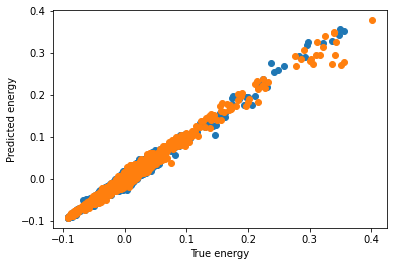

In [115]:
plt.plot(np_true0,np_pred0,'o',label='batch 0')
plt.plot(np_true1,np_pred1,'o',label='batch 0')

plt.xlabel("True energy")
plt.ylabel("Predicted energy")

## Bibliography:

* This document is based on the notebook found in https://aiqm.github.io/torchani-test-docs/examples/nnp_training.html.
However, in this exercise, we add some additional explanations and exercises about ANI that will help the student understand the topic better and can be linked to the lecture better.

* `smith2017-1` refers to the ANI-1 paper, available at https://doi.org/10.1039/C6SC05720A.

* Other references are included throughout the notebook as direct links